In [1]:
import keras
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import misc
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
import pickle
%matplotlib inline

Using TensorFlow backend.


In [2]:
test_img_fnames = os.listdir('data/test')
train_img_fnames = os.listdir('data/train')

FileNotFoundError: [Errno 2] No such file or directory: 'data/test'

# Load in the data
First we need to write a function to load into memory each of the images, and then resize them to (224, 224, 3). scipy.misc.imread and scipy.misc.imresize will be useful for this. You should also rescale the images so that they are on a scale of 0 to 1, meaning each pixel value should be between 0 and 1. This can be achieved by dividing by an appropriate constant.

In [7]:
def load_img(filename):
    img = misc.imresize(misc.imread(filename), (224, 224, 3))
    return img/255

In [8]:
test_imgs = [load_img(os.path.join('data/test', fname)) for fname in test_img_fnames[:int(len(test_img_fnames)/75)]]
test_imgs = np.stack(test_imgs)

In [9]:
train_imgs = [load_img(os.path.join('data/train', fname)) for fname in train_img_fnames[:int(len(train_img_fnames)/75)]]
train_imgs = np.stack(train_imgs)

In [10]:
with open('data/train_labels.pkl', 'rb') as f:
    train_labels = pickle.load(f)

# Load Pretrained VGG network
Now in order to generate the CNN featurizations of our images we need to load a pretrained network. Note that running this network will take a long time on CPU so you can feel free to skip this section and just load the featurizations I provided in the next section

In [11]:
VGG16 = keras.applications.vgg16.VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 24s 0us/step


In [12]:
VGG16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [13]:
featurized_training_data = VGG16.predict(train_imgs, verbose=1)

300/300 [==============================] - 312s 1s/step


In [14]:
featurized_test_data = VGG16.predict(test_imgs, verbose=1)

33/33 [==============================] - 35s 1s/step


In [15]:
# Save featurizations
import pickle
with open('featurized_train_imgs.pkl', 'wb') as f:
    pickle.dump(featurized_training_data, f)
with open('featurized_test_imgs.pkl', 'wb') as f:
    pickle.dump(featurized_test_data, f)

# Load featurizations

In [16]:
import pickle
with open('featurized_train_imgs.pkl', 'rb') as f:
    featurized_training_data = pickle.load(f)
with open('featurized_test_imgs.pkl', 'rb') as f:
    featurized_test_data = pickle.load(f)

# Create you network
Now we need to create a network to take in the featurizations and output a label of dog or not dog. To do this you should use Keras' Sequential model. We will need to flatten our (7,7,512) feature input into a vector (HINT: lookup flatten in keras documentation) and then add a Dense layer with some number of neurons (play around with the number of neurons to improve your performance). Then finally we need a Dense layer with 1 neuron and a sigmoid activation to represent our label output. You might want to use more or less model.add calls than have been provided

In [17]:
model = Sequential()
model.add(Flatten(input_shape=(7,7,512)))
model.add(Dense(10))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                250890    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 250,901
Trainable params: 250,901
Non-trainable params: 0
_________________________________________________________________


# Now we need to train the network
You need to compile the model first, and then use the fit function. You should use binary crossentropy as your loss.

In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy')

In [20]:
model.fit(featurized_training_data, train_labels[:300])

Epoch 1/10
300/300 [==============================] - 1s 2ms/step - loss: 1.5990
Epoch 2/10
300/300 [==============================] - 0s 580us/step - loss: 0.7703
Epoch 3/10
300/300 [==============================] - 0s 563us/step - loss: 0.3841
Epoch 4/10
300/300 [==============================] - 0s 540us/step - loss: 0.2255
Epoch 5/10
300/300 [==============================] - 0s 649us/step - loss: 0.1642
Epoch 6/10
300/300 [==============================] - 0s 673us/step - loss: 0.1134
Epoch 7/10
300/300 [==============================] - 0s 553us/step - loss: 0.1075
Epoch 8/10
300/300 [==============================] - 0s 585us/step - loss: 0.0770
Epoch 9/10
300/300 [==============================] - 0s 635us/step - loss: 0.0570
Epoch 10/10
300/300 [==============================] - 0s 633us/step - loss: 0.0515


Now we need to predict labels for the test set and output it to file. Use keras predict for this. Remember that the predictions are real values between 0 and 1 and you should be outputting just 0 or 1, not a value between.

In [21]:
predictions = model.predict(featurized_test_data)

In [22]:
predictions

array([[ 0.58178967],
       [ 0.40153873],
       [ 0.88303244],
       [ 0.96911478],
       [ 0.73014301],
       [ 0.46376216],
       [ 0.40030923],
       [ 0.29820117],
       [ 0.58268738],
       [ 0.73465151],
       [ 0.90799439],
       [ 0.63767987],
       [ 0.3573364 ],
       [ 0.85504109],
       [ 0.54277343],
       [ 0.0627545 ],
       [ 0.94950145],
       [ 0.25238225],
       [ 0.89479232],
       [ 0.74804914],
       [ 0.96819043],
       [ 0.66873372],
       [ 0.32143807],
       [ 0.75173295],
       [ 0.69009686],
       [ 0.40648577],
       [ 0.84043729],
       [ 0.60005975],
       [ 0.59508038],
       [ 0.98049659],
       [ 0.37798864],
       [ 0.56766665],
       [ 0.22702105]], dtype=float32)

In [24]:
with open('test_labels.txt', 'w') as f:
    f.write("Id,Label\n")
    for i, val in enumerate(predictions):
        prediction = 0 if val < 0.5 else 1
        f.write(str(i))
        f.write('\n')
        f.write(str(prediction))
        f.write('\n')

# Part 2

In [25]:
from sklearn.decomposition import PCA

Now we want to run PCA on our images and our featurizations to see the difference. To save time we will just run it on the first 500 images. Take the first 500 images and 500 featurizations and reshape them into shape (500, x).

In [38]:
original_imgs = train_imgs[:500]
featurized = featurized_training_data[:500]

ValueError: cannot reshape array of size 45158400 into shape (300,)

In [40]:
type(original_imgs)
print(original_imgs.shape)
print(train_imgs.shape)
print(original_imgs.flatten())

(300, 224, 224, 3)
(300, 224, 224, 3)
[ 0.20392157  0.18431373  0.17254902 ...,  0.52156863  0.34117647
  0.20392157]


In [50]:
temp = []
for img in original_imgs:
    temp += [img.flatten()]
original_imgs = np.array(temp)

temp = []
for img in featurized:
    temp += [img.flatten()]
featurized = np.array(temp)

In [51]:
featurized.shape

(300, 25088)

Run PCA with 2 components on the original images

In [53]:
pca_orig = PCA(2)
pca_orig.fit(original_imgs)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Run PCA with 2 components on the featurizations

In [54]:
pca_featurized = PCA(2)
pca_featurized.fit(featurized)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Project the original images and featurizations onto the 2 principal components. (HINT: look at the PCA.transform function)

In [55]:
projected_orig_imgs = pca_orig.transform(original_imgs)
projected_featurized = pca_featurized.transform(featurized)

Find the indices of the labels that are cats and the indices that are dogs. np.where will make this very easy

In [59]:
labels = train_labels[:300]
labels.shape

(500,)

In [60]:
labels = train_labels[:300]
cat_inds = np.where(labels==0)[0]
dog_inds = np.where(labels==1)[0]

Plot the PCA of the original images and the PCA of the featurization

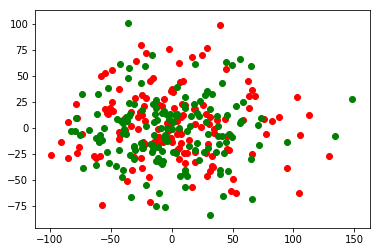

In [61]:
plt.scatter(projected_orig_imgs[cat_inds ,0], projected_orig_imgs[cat_inds, 1], c='red')
plt.scatter(projected_orig_imgs[dog_inds, 0], projected_orig_imgs[dog_inds, 1], c='green')

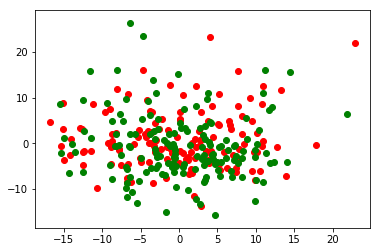

In [62]:
plt.scatter(projected_featurized[cat_inds ,0], projected_featurized[cat_inds, 1], c='red')
plt.scatter(projected_featurized[dog_inds, 0], projected_featurized[dog_inds, 1], c='green')

Question 1: 
    
In terms of how separate the clusters are, they all are centered around (0,0). However, in terms of the sizes of the clusters, they are a lot less spread out across the two principal components in our featurized plot, as seen from the values along the axes of both plots; the max value range in the un-featurized plot for our components are roughly from -100 to 150, whereas that of the featurized plot is roughly only -20 to 30. This means that the featurized data is more tightly clustered. 

Question 2:

As said in the spec, training a CNN takes really long. Visually, with the plots, this can be understood with the larger range of values being taken on by the un-featurized plot, which would intuitively correspond to longer training times. Conversely, featurization allows the classification model to better 'focus' on more important parts of the data, which should also intuitively correspond to shorter training times. 